# First basic analysis of input data files

 A bunch of import and setup stuff

In [67]:
import numpy
import pandas
import os
import gc
import matplotlib.pyplot as plot
import unicodedata
import seaborn as sns
# This is upposed to enhance default pandas display
pandas.set_option('display.width',120)



Play a little bit with infos from os

*Note*
* Only difference between {train/test}_without_quotes_final and {train/test}  is the weird encoding of "" for " inside a field is replaced with a simple '
This allows to easily import data in HANA. With my background in SQL, some simple analysis are easy to do with HANA (cf SQL/import_and_sniff{train/test})

In [4]:

print('Content of input folder')
file_list = os.listdir('../input')
file_list.sort()
for file in file_list:
        print('%s%.0f\tMB' % (file.ljust(35),os.path.getsize('../input/' + file) / (1024*1024)))

Content of input folder
sample_submission.csv              21	MB
test.csv                           299	MB
test_without_quotes_final.csv      299	MB
train.csv                          60	MB
train_without_quotes_final.csv     60	MB


Time to ingest data

*Note* To avoid further confusion, test dataframe is named challenge_df


In [5]:
# Strong checks are default but I prefer to have it clearly activated
train_dataframe = pandas.read_csv('../input/train.csv',error_bad_lines=True,warn_bad_lines=True)
train_dataframe.metadata = {'title': 'Train'}

challenge_dataframe = pandas.read_csv('../input/test.csv',error_bad_lines=True,warn_bad_lines=True)
challenge_dataframe.metadata = {'title': 'Challenge'}



## Very low level checks#:
* How csv has been read (empty value is replaced by a NaN)
* Is there some unicode mess in data

In [6]:
def check_unicode(s):
    if type(s)==str and not unicodedata.is_normalized('NFKD',s):
        return True
    else:
        return False

def check_what_has_been_read(df):
    print('\n%s\n'% df.metadata['title'])
    print('question1 empty and needing to be forced to "": %d' % df['question1'].isnull().sum())
    print('question1 is not a string (a number, a date,...): %d' % df['question1'].apply(lambda s: type(s) !=str).sum())
    print('poorly encoded unicode data in question1: %d' % df['question1'].apply(check_unicode).sum())
    print('question2 and needing to be forced to "": %d' % df['question2'].isnull().sum())
    print('question2 is not a string (a number, a date,...): %d' % df['question2'].apply(lambda s: type(s) !=str).sum())
    print('poorly encoded unicode data in question2: %d' % df['question2'].apply(check_unicode).sum())


check_what_has_been_read(train_dataframe)
check_what_has_been_read(challenge_dataframe)


Train

question1 empty and needing to be forced to "": 1
question1 is not a string (a number, a date,...): 1
poorly encoded unicode data in question1: 1336
question2 and needing to be forced to "": 2
question2 is not a string (a number, a date,...): 2
poorly encoded unicode data in question2: 1247

Challenge

question1 empty and needing to be forced to "": 2
question1 is not a string (a number, a date,...): 2
poorly encoded unicode data in question1: 8229
question2 and needing to be forced to "": 4
question2 is not a string (a number, a date,...): 4
poorly encoded unicode data in question2: 7922


Some questions are NaN. Some with bad encoding. This will be paintfull to manage later. Fix it

In [7]:
def fix_unicode(s):
    if not unicodedata.is_normalized('NFKD',s):
        return unicodedata.normalize('NFKD',s)
    else:
        return s

def fix_what_has_been_read(df):
    print('\n%s\n' % df.metadata['title'])
    print('Fix Nan')
    df.fillna('',inplace=True)
    print('Fix unicode')
    a = df['question1'].apply(fix_unicode)
    df['question1'] = a
    a = df['question2'].apply(fix_unicode)
    df['question2'] = a
    


fix_what_has_been_read(train_dataframe)
fix_what_has_been_read(challenge_dataframe)




Train

Fix Nan
Fix unicode

Challenge

Fix Nan
Fix unicode


Recheck everything

In [8]:
check_what_has_been_read(train_dataframe)
check_what_has_been_read(challenge_dataframe)


Train

question1 empty and needing to be forced to "": 0
question1 is not a string (a number, a date,...): 0
poorly encoded unicode data in question1: 0
question2 and needing to be forced to "": 0
question2 is not a string (a number, a date,...): 0
poorly encoded unicode data in question2: 0

Challenge

question1 empty and needing to be forced to "": 0
question1 is not a string (a number, a date,...): 0
poorly encoded unicode data in question1: 0
question2 and needing to be forced to "": 0
question2 is not a string (a number, a date,...): 0
poorly encoded unicode data in question2: 0


## Do some saves

In [15]:
def save_dataframe0(store,df,name):
    print('Save %s in %s' % (df.metadata['title'],name) )
    if '/'+name in store.keys():
        store.remove(name)
    store[name] = df
    store.get_storer(name).attrs.metadata = df.metadata

def load_dataframe0(store,name):
    print ('load %s' % name)
    df= store[name]
    df.metadata = store.get_storer(name).attrs.metadata
    print ('%s has been retrieved in %s ' % (df.metadata['title'], name))
    print('%s contains %d lines' % (df.metadata['title'],len(df)))
    return df


def save_dataframe(df,file_name):
    print('Save %s in %s' % (df.metadata['title'],name) )
    df.to_pickle('../PandasStore/'+file_name+'.pkl')
    

save_dataframe(train_dataframe,'clean_training')
save_dataframe(challenge_dataframe,'clean_challenge')



Save Train in clean_training
Save Challenge in clean_challenge


## Try reloads

In [22]:

def load_dataframe(file_name,title):
    print ('load %s' % file_name)
    df = pandas.read_pickle('../PandasStore/'+file_name+'.pkl')
    print('%s contains %d lines' % (title,len(df)))
    df.metadata={'title':title}
    return df

train_dataframe = load_dataframe('clean_training','Train')
challenge_dataframe = load_dataframe('clean_challenge','Challenge')

load clean_training
Train contains 404290 lines
load clean_challenge
Challenge contains 2345796 lines


In [9]:
### train

In [23]:
train_dataframe

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


### challenge

In [24]:
challenge_dataframe

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
...,...,...,...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...


## Some basic stats on datasets
### Train

In [89]:

properties_train={
    'Nb unique id': numpy.sum(train_dataframe['id'].value_counts()==1),
    'Nb pairs': len(train_dataframe),
    'Nb duplicate=1':numpy.sum(train_dataframe['is_duplicate']==1),
    'Nb duplicate': train_dataframe['is_duplicate'].sum(),
    'Unique values in duplicate': train_dataframe['is_duplicate'].unique(),
    'Nb unique values in duplicate': train_dataframe['is_duplicate'].unique().shape[0],
    '% duplicate': train_dataframe['is_duplicate'].mean()*100,
    'Nb unique qid1': numpy.sum(train_dataframe['qid1'].value_counts()==1),
    'Nb unique qid2': numpy.sum(train_dataframe['qid2'].value_counts()==1),
    'Nb qid1=qid2':numpy.sum(train_dataframe['qid1']==train_dataframe['qid2']),
    'Nb question1=question2': numpy.sum(train_dataframe['question1']==train_dataframe['question2']),
    'Nb lower(question1)=lower(question2)': numpy.sum(train_dataframe['question1'].str.lower()==train_dataframe['question2'].str.lower()),
    'lower(question1))=lower(question2)': train_dataframe[train_dataframe['question1'].str.lower()==train_dataframe['question2'].str.lower()],
    'mean(len(question1))':train_dataframe['question1'].str.len().mean(),
    'mean(len(question2))':train_dataframe['question2'].str.len().mean(),
}
properties_train

{'Nb unique id': 404290,
 'Nb pairs': 404290,
 'Nb duplicate=1': 149263,
 'Nb duplicate': 149263,
 'Unique values in duplicate': array([0, 1], dtype=int64),
 'Nb unique values in duplicate': 2,
 '% duplicate': 36.9197853026293,
 'Nb unique qid1': 236581,
 'Nb unique qid2': 253733,
 'Nb qid1=qid2': 0,
 'Nb question1=question2': 0,
 'Nb lower(question1)=lower(question2)': 1,
 'lower(question1))=lower(question2)':             id    qid1    qid2                       question1                       question2  is_duplicate
 338489  338489  466050  466051  What do you think of BuzzFeed?  What do you think of Buzzfeed?             1,
 'mean(len(question1))': 59.54156422370081,
 'mean(len(question2))': 60.11258997254446}

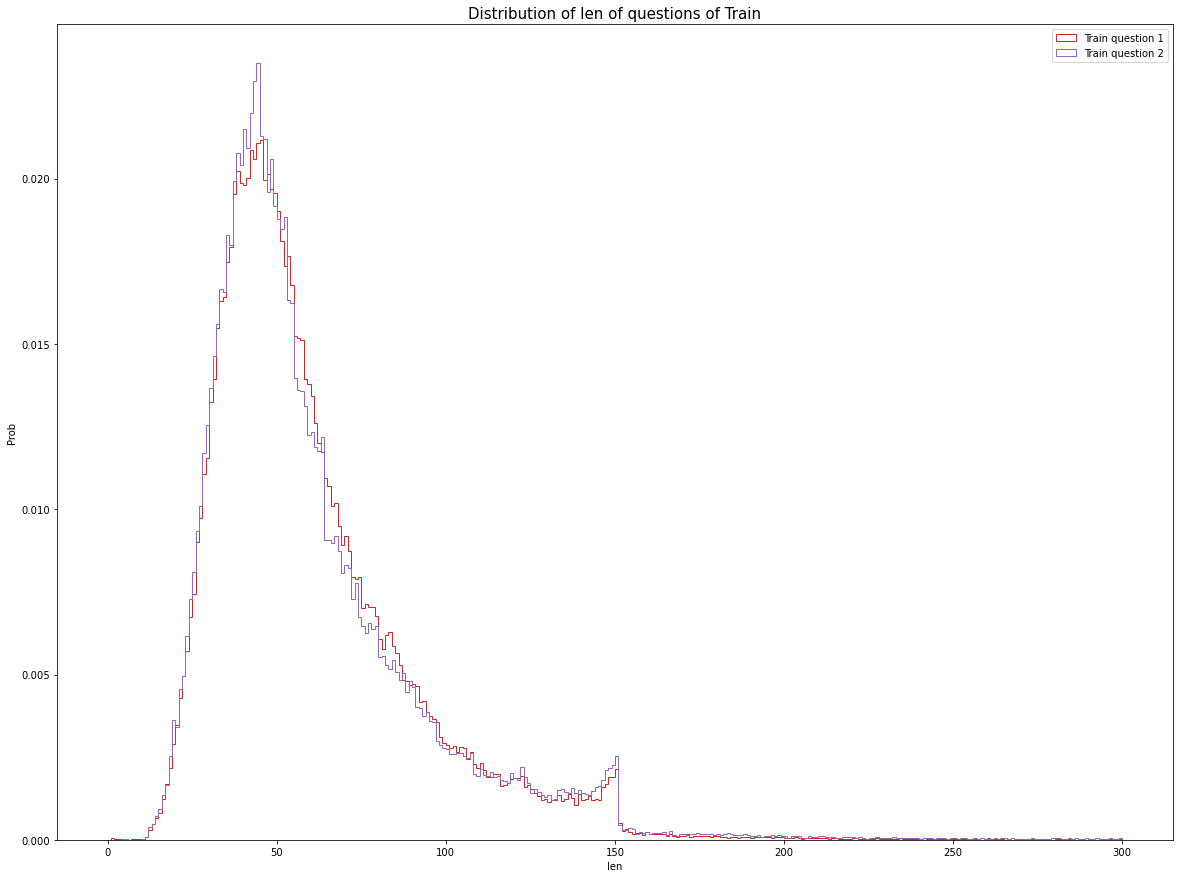

In [85]:
palette = sns.color_palette()
plot.figure(figsize=(20, 15))
plot.hist(train_dataframe['question1'].str.len(),bins=300,range=[0,300],density=True,color=palette[3],label='Train question 1',histtype='step')
plot.hist(train_dataframe['question2'].str.len(),bins=300,range=[0,300],density=True,color=palette[4],label='Train question 2',alpha=1,histtype='step')
plot.title('Distribution of len of questions of Train', fontsize=15)
plot.xlabel('len')
plot.ylabel('Prob')
plot.legend()

### Challenge

In [90]:
properties_challenge={
    'Nb unique id': numpy.sum(challenge_dataframe['test_id'].value_counts()==1),
    'Nb pairs': len(challenge_dataframe),
    'Nb unique test_id': numpy.sum(challenge_dataframe['test_id'].value_counts()==1),
    'Nb question1=question2': numpy.sum(challenge_dataframe['question1']==challenge_dataframe['question2']),
    'Nb lower(question1)=lower(question2)': numpy.sum(challenge_dataframe['question1'].str.lower()==challenge_dataframe['question2'].str.lower()),
    'lower(question1))=lower(question2)': challenge_dataframe[challenge_dataframe['question1'].str.lower()==challenge_dataframe['question2'].str.lower()],
    'mean(len(question1))':challenge_dataframe['question1'].str.len().mean(),
    'mean(len(question2))':challenge_dataframe['question2'].str.len().mean(),
}

properties_challenge


{'Nb unique id': 2345796,
 'Nb pairs': 2345796,
 'Nb unique test_id': 2345796,
 'Nb question1=question2': 60,
 'Nb lower(question1)=lower(question2)': 64,
 'lower(question1))=lower(question2)':          test_id                           question1                           question2
 10620      10620            What is the police code?            What is the police code?
 37823      37823                           How love?                           How love?
 43119      43119                            What is?                            What is?
 106366    106366                        What is the                         What is the 
 122915    122915                      What Xbox 360?                      what Xbox 360?
 ...          ...                                 ...                                 ...
 2237047  2237047  What are the best dating in India?  What are the best dating in India?
 2252447  2252447                     What radiation?                     What radiatio

In [ ]:
palette = sns.color_palette()
plot.figure(figsize=(20, 15))
plot.hist(challenge_dataframe['question1'].str.len(),bins=300,range=[0,300],density=True,color=palette[3],label='Challenge question 1',histtype='step')
plot.hist(challenge_dataframe['question2'].str.len(),bins=300,range=[0,300],density=True,color=palette[4],label='Challenge question 2',alpha=1,histtype='step')
plot.title('Distribution of len of questions of Challenge', fontsize=15)
plot.xlabel('len')
plot.ylabel('Prob')
plot.legend()

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
808575    How many keywords are there in PERL Programmin...
808576           Is it true that there is life after death?
808577                                    What's this coin?
808578    I am having little hairfall problem but I want...
808579        What is it like to have sex with your cousin?
Name: question, Length: 808580, dtype: object

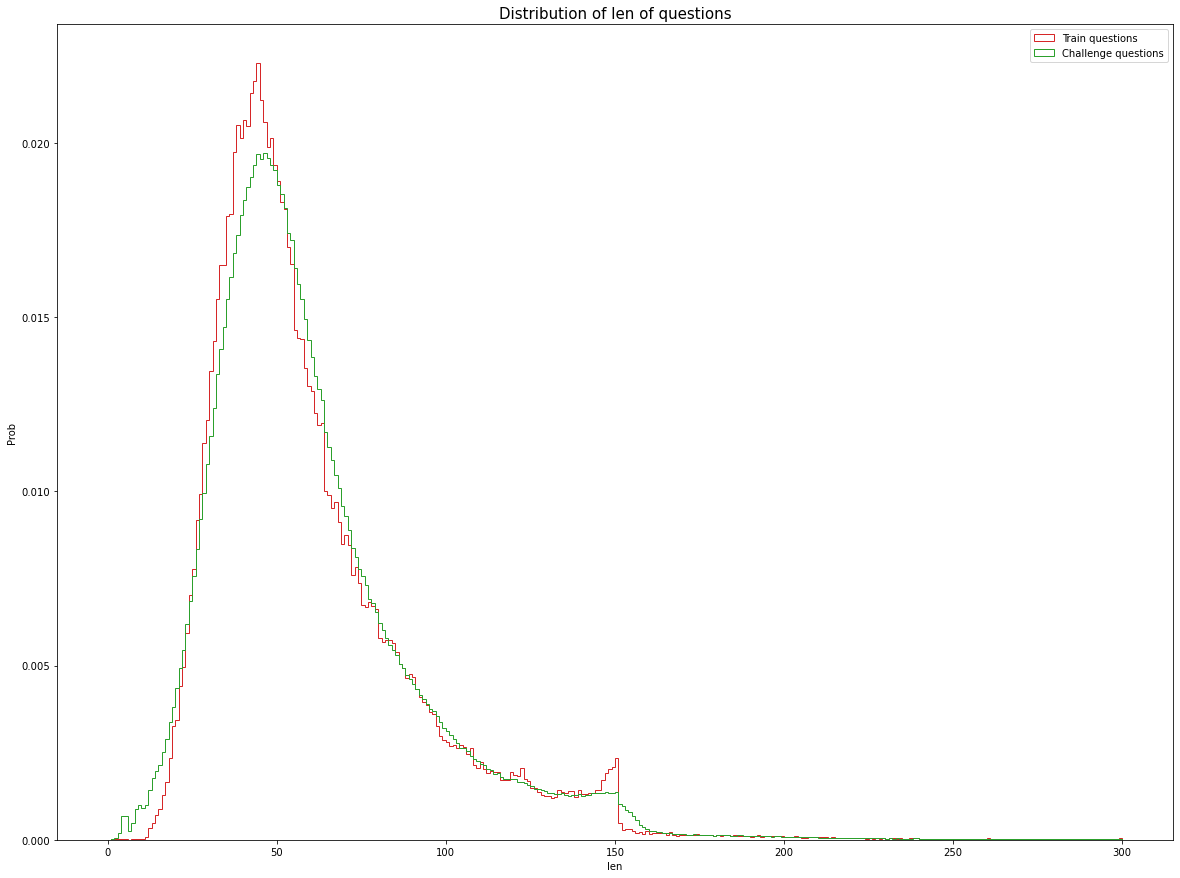

In [116]:
all_train_questions = pandas.Series(train_dataframe['question1'].to_list() + train_dataframe['question2'].to_list(),name='question')
all_challenge_questions = pandas.Series(challenge_dataframe['question1'].to_list() + challenge_dataframe['question2'].to_list(),name='question')

palette = sns.color_palette()
plot.figure(figsize=(20, 15))
plot.hist(all_train_questions.str.len(),bins=300,range=[0,300],density=True,color=palette[3],label='Train questions',histtype='step')
plot.hist(all_challenge_questions.str.len(),bins=300,range=[0,300],density=True,color=palette[2],label='Challenge questions',alpha=1,histtype='step')
plot.title('Distribution of len of questions', fontsize=15)
plot.xlabel('len')
plot.ylabel('Prob')
plot.legend()




In [147]:
words_of_train_questions = pandas.DataFrame(all_train_questions)
words_of_train_questions['Length'] = all_train_questions.str.len()
words_of_train_questions['NbWords'] = all_train_questions.apply(lambda s: len(s.split(' ')))
words_of_train_questions['MaxLengthWord'] = all_train_questions.apply(lambda s: numpy.max([ len(w) for w in s.split(' ')]))
words_of_train_questions['MeanLengthWord'] = all_train_questions.apply(lambda s: numpy.mean([ len(w) for w in s.split(' ')]))
words_of_train_questions

,question,Length,NbWords,MaxLengthWord,MeanLengthWord
0,What is the step by step guide to invest in sh...,66,14,6,3.785714
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,51,8,12,5.500000
2,How can I increase the speed of my internet co...,73,14,10,4.285714
3,Why am I mentally very lonely? How can I solve...,50,11,8,3.636364
4,"Which one dissolve in water quikly sugar, salt...",76,13,8,4.923077
...,...,...,...,...,...
808575,How many keywords are there in PERL Programmin...,79,13,11,5.153846
808576,Is it true that there is life after death?,42,9,6,3.777778
808577,What's this coin?,17,3,6,5.000000
808578,I am having little hairfall problem but I want...,127,25,8,4.120000


In [148]:
words_of_challenge_questions = pandas.DataFrame(all_challenge_questions)
words_of_challenge_questions['Length'] = all_challenge_questions.str.len()
words_of_challenge_questions['NbWords'] = all_challenge_questions.apply(lambda s: len(s.split(' ')))
words_of_challenge_questions['MaxLengthWord'] = all_challenge_questions.apply(lambda s: numpy.max([ len(w) for w in s.split(' ')]))
words_of_challenge_questions['MeanLengthWord'] = all_challenge_questions.apply(lambda s: numpy.mean([ len(w) for w in s.split(' ')]))
words_of_challenge_questions

,question,Length,NbWords,MaxLengthWord,MeanLengthWord
0,How does the Surface Pro himself 4 compare wit...,57,11,7,4.272727
1,Should I have a hair transplant at age 24? How...,66,14,10,3.785714
2,What but is the best way to send money from Ch...,60,14,5,3.357143
3,Which food not emulsifiers?,27,4,12,6.000000
4,"How ""aberystwyth"" start reading?",32,4,13,7.250000
...,...,...,...,...,...
4691587,What is the most study scene in twin peaks?,43,9,6,3.888889
4691588,How question FedEx packages delivered?,38,5,10,6.800000
4691589,Can a non-alcoholic restaurant be a huge success?,49,8,13,5.250000
4691590,What are the best and worst things examination...,128,20,14,5.450000
